In [1]:
import math
import numpy as np
import pandas as pd

from datetime import datetime

import matplotlib.pyplot as plt
from scipy.integrate import odeint
import statsmodels.api as sm

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

plt.style.use('ggplot')
font_size = 14
plt.rcParams.update({'font.size': font_size})

In [2]:
def open_merge_files(infection_file_path, df_population):
    df_usa_rates = pd.read_csv(infection_file_path)
    df_usa_rates['datetime'] = pd.to_datetime(df_usa_rates['date'].astype(str), format='%Y%m%d')
    df_usa_rates['d_o_y'] = pd.DatetimeIndex(df_usa_rates['datetime']).dayofyear
    
    df_usa = pd.merge(df_usa_rates, df_population, how='outer', left_on='state', right_on='ABBR',
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)[['datetime','d_o_y','NAME', 'state', 'POPESTIMATE2019','positiveIncrease', 
                         'positive', 'negativeIncrease', 'negative', 'pending', 'deathIncrease', 'death', 'recovered', 
                         'hospitalizedIncrease','hospitalized','totalTestResultsIncrease',
                         'totalTestResults','posNeg','total']]
    df_usa.columns = ['datetime','d_o_y','state_name', 'state_id', 'state_pop_2019','positive_daily_incr', 
                  'positive_cum', 'negative_daily_incr', 'negative_cum', 'pending_daily','death_daily_incr', 
                  'death_cum', 'recovered_cum', 'hospitalized_daily_incr','hospitalized_cum',
                  'total_test_results_daily_incr','total_test_results_cum','test_pos_neg_cum','total_tests_cum']
    return df_usa

In [13]:
df_usa_pop = pd.read_csv('../data/us_state_population_2019.csv')

In [14]:
df_usa = open_merge_files('../data/us_states_covid19_daily.csv', df_usa_pop)

In [5]:
df_usa

,datetime,d_o_y,state_name,state_id,state_pop_2019,positive_daily_incr,positive_cum,negative_daily_incr,negative_cum,pending_daily,death_daily_incr,death_cum,recovered_cum,hospitalized_daily_incr,hospitalized_cum,total_test_results_daily_incr,total_test_results_cum,test_pos_neg_cum,total_tests_cum
0,2020-05-10,131.0,Alaska,AK,731545.0,1.0,379.0,914.0,26985.0,NaN,0.0,10.0,324.0,0.0,NaN,915.0,27364.0,27364.0,27364.0
1,2020-05-09,130.0,Alaska,AK,731545.0,1.0,378.0,975.0,26071.0,NaN,0.0,10.0,318.0,0.0,NaN,976.0,26449.0,26449.0,26449.0
2,2020-05-08,129.0,Alaska,AK,731545.0,3.0,377.0,1129.0,25096.0,NaN,0.0,10.0,305.0,0.0,NaN,1132.0,25473.0,25473.0,25473.0
3,2020-05-07,128.0,Alaska,AK,731545.0,2.0,374.0,684.0,23967.0,NaN,0.0,10.0,291.0,0.0,NaN,686.0,24341.0,24341.0,24341.0
4,2020-05-06,127.0,Alaska,AK,731545.0,1.0,372.0,962.0,23283.0,NaN,1.0,10.0,284.0,0.0,NaN,963.0,23655.0,23655.0,23655.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3709,2020-03-11,71.0,Wyoming,WY,578759.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0
3710,2020-03-10,70.0,Wyoming,WY,578759.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0
3711,2020-03-09,69.0,Wyoming,WY,578759.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0
3712,2020-03-08,68.0,Wyoming,WY,578759.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0


In [7]:
metric_dict = {'infection' : ['positive_daily_incr', 'Infections', 'Infection Counts', 'infection_counts'],
                   'hospitalized' : ['hospitalized_daily_incr', 'Hospitializations', 'Hospitializations', 'hospitializations'],
                   'death' : ['death_daily_incr', 'Deaths', 'Deaths', 'deaths']}

In [10]:
metric_dict['infection'][3]

'infection_counts'

In [15]:
def plot_infection_trends(state_list, metric = 'infection'):
    num_days_smooth = 7
    metric_dict = {'infection' : ['positive_daily_incr', 'Infections', 'Infection Counts', 'infection_counts'],
                   'hospitalized' : ['hospitalized_daily_incr', 'Hospitializations', 'Hospitializations', 'hospitializations'],
                   'death' : ['death_daily_incr', 'Deaths', 'Deaths', 'deaths']}
    
    # Setting up Subplot layout
    plt_row = len(state_list) // 2
    if len(state_list) > 1:
        plt_col = 2
    else:
        plt_col = 1
    fig_sz_row = 2 + 3 * plt_row
    fig, axes = plt.subplots(plt_row,plt_col,figsize = (15,fig_sz_row), sharex=True, sharey=True)
    
    for ax, state in zip(axes.flat, state_list):
        # Setting up rolling avg and reopen threshold data
        state_pop = df_usa_pop.loc[df_usa_pop['ABBR'] == state,['POPEST18PLUS2019']].iloc[0,0] 
        state_reopen_thresh = math.ceil(state_pop * reopen_thresh) 
        df2 = df_usa[df_usa['state_id']==state]
        df2['Rolling-{num_days_smooth}mean'] = df2[metric_dict[metric][0]].rolling(window=num_days_smooth, center = True).mean()
        # Data plotted
        ax.bar(df2.d_o_y, df2[metric_dict[metric][0]], label = f"{state}")
        plt.plot(df2.d_o_y, df2['Rolling-{num_days_smooth}mean'], label = f"{state}: {num_days_smooth}-Day Smooth", color='blue')
        ax.axhline(state_reopen_thresh, color = 'black', ls="--", label = f"Reopen Threshold = {state_reopen_thresh}")
        # Major & minor ticks
        ax.xaxis.set_major_locator(MultipleLocator(5))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
        ax.xaxis.set_minor_locator(MultipleLocator(1))
        ax.tick_params(direction='out', length=10)
        # Axis Labels
        ax.set_xlabel('Day of Year (2020)') 
        ax.set_ylabel(f'Reported {metric_dict[metric][1]}') 
        ax.label_outer()
        # Coerce Legend to dsplay in desired order
        handles, labels = plt.gca().get_legend_handles_labels()
        order = [2,0,1]
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
                  fontsize=12, loc='upper left')
    plt.suptitle(f'{metric_dict[metric][2]} By Day of Year, By State', fontsize=16, y = 0.95)
    plt.show();
    states_str = "-".join(state_list)
    fig.savefig(f"../images/{metric_dict[metric][3]}_by_doy_smoothed_thresh-{states_str}.png", dpi=250)

In [16]:
plot_infection_trends(['NY'], metric = 'infection')

<Figure size 1080x144 with 0 Axes>

In [31]:
state_list = ['NY']
metric = 'infection'
num_days_smooth = 7
metric_dict = {'infection' : ['positive_daily_incr', 'Infections', 'Infection Counts', 'infection_counts'],
               'hospitalized' : ['hospitalized_daily_incr', 'Hospitializations', 'Hospitializations', 'hospitializations'],
               'death' : ['death_daily_incr', 'Deaths', 'Deaths', 'deaths']}

# Setting up Subplot layout
plt_row = np.maximum(len(state_list) // 2, 1)
if len(state_list) > 1:
    plt_col = 2
else:
    plt_col = 1
fig_sz_row = 2 + 3 * plt_row
print(plt_row, plt_col, fig_sz_row)

0 1 2


In [27]:
reopen_thresh = 10./100000/14
state_pop = df_usa_pop.loc[df_usa_pop['ABBR'] == state_list[0],['POPEST18PLUS2019']].iloc[0,0] 
print(state_pop)
state_reopen_thresh = math.ceil(state_pop * reopen_thresh)
print(state_reopen_thresh)

15425262
111


In [28]:
fig, axes = plt.subplots(plt_row,plt_col,figsize = (15,fig_sz_row), sharex=True, sharey=True)
for ax, state in zip(axes.flat, state_list):
    # Setting up rolling avg and reopen threshold data
    state_pop = df_usa_pop.loc[df_usa_pop['ABBR'] == state,['POPEST18PLUS2019']].iloc[0,0] 
    print(state)
    state_reopen_thresh = math.ceil(state_pop * reopen_thresh) 
    df2 = df_usa[df_usa['state_id']==state]
    df2['Rolling-{num_days_smooth}mean'] = df2[metric_dict[metric][0]].rolling(window=num_days_smooth, center = True).mean()
    # Data plotted
    ax.bar(df2.d_o_y, df2[metric_dict[metric][0]], label = f"{state}")
    plt.plot(df2.d_o_y, df2['Rolling-{num_days_smooth}mean'], label = f"{state}: {num_days_smooth}-Day Smooth", color='blue')
    ax.axhline(state_reopen_thresh, color = 'black', ls="--", label = f"Reopen Threshold = {state_reopen_thresh}")
    # Major & minor ticks
#     ax.xaxis.set_major_locator(MultipleLocator(5))
#     ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
#     ax.xaxis.set_minor_locator(MultipleLocator(1))
#     ax.tick_params(direction='out', length=10)
#     # Axis Labels
#     ax.set_xlabel('Day of Year (2020)') 
#     ax.set_ylabel(f'Reported {metric_dict[metric][1]}') 
#     ax.label_outer()
#     # Coerce Legend to dsplay in desired order
#     handles, labels = plt.gca().get_legend_handles_labels()
#     order = [2,0,1]
#     ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
#               fontsize=12, loc='upper left')
# plt.suptitle(f'{metric_dict[metric][2]} By Day of Year, By State', fontsize=16, y = 0.95)
# plt.show();

<Figure size 1080x144 with 0 Axes>

/home/asa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


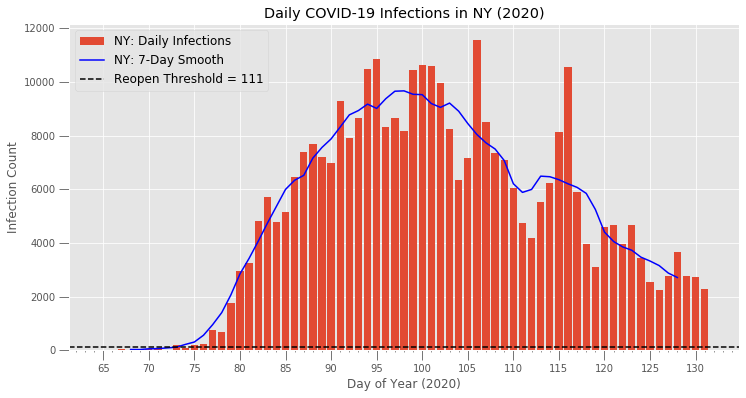

In [36]:
# CDC guideline threshold of 10 reported infections per 100k pop every 14 days
reopen_thresh = 10./100000/14

# states = ['NY', 'FL', 'CA']
state_list = ['NY']
metric_dict = {'infection' : ['positive_daily_incr', 'Infections', 'Infection Counts', 'infection_counts'],
                   'hospitalized' : ['hospitalized_daily_incr', 'Hospitializations', 'Hospitializations', 'hospitializations'],
                   'death' : ['death_daily_incr', 'Deaths', 'Deaths', 'deaths']}

states_pop = [df_usa_pop.loc[df_usa_pop['ABBR'] == state_list[i],['POPEST18PLUS2019']].iloc[0,0] for i in range(len(states))]
state_reopen_thresh = [math.ceil(x * reopen_thresh) for x in states_pop]
num_days = 7
df2 = df_usa[df_usa['state_id'].isin(state_list)]
df2['Rolling-{num_days}mean'] = df2[metric_dict[metric][0]].rolling(window=num_days, center = True).mean()
fig, ax = plt.subplots(figsize = (12,6))
for state in state_list:
    plt.bar(df2.d_o_y, df2[metric_dict[metric][0]], label = f"{state}: Daily Infections")
    plt.plot(df2.d_o_y, df2['Rolling-{num_days}mean'], label = f"{state}: {num_days}-Day Smooth", color='blue')
    
    ax.axhline(state_reopen_thresh[0], color = 'black', ls="--", label = f"Reopen Threshold = {state_reopen_thresh[0]}")

    
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(direction='out', length=10)
ax.set_xlabel('Day of Year (2020)')
ax.set_ylabel('Infection Count')
plt.title(f'Daily COVID-19 Infections in {state} (2020)')
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12,loc='upper left')
plt.show();